In [ ]:
%pip install requests beautifulsoup4 pandas xlsxwriter #remove this line after running for the first time
import requests
from bs4 import BeautifulSoup
import pandas as pd
import csv

### Paste Google Sheets URL here
#### The sheet must be a list of steam urls listed in a single column

In [47]:
sheet_url = ""

##### Paste VGI JWT below
##### JWT can be obtained by creating a free account on VGInsights and finding the authorization header from one of their API calls

#### Instructions For Obtaining JWT Token (Chrome):

Go to a game page on VGInsights

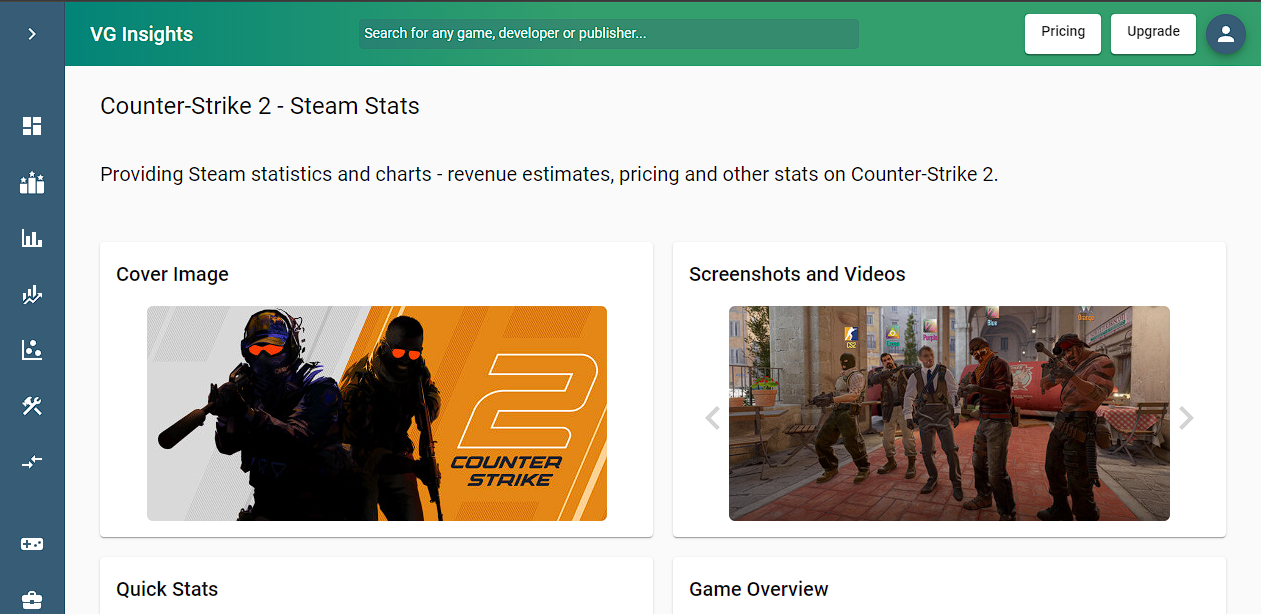

Open developer tools for that page and navigate to the 'Network' tab

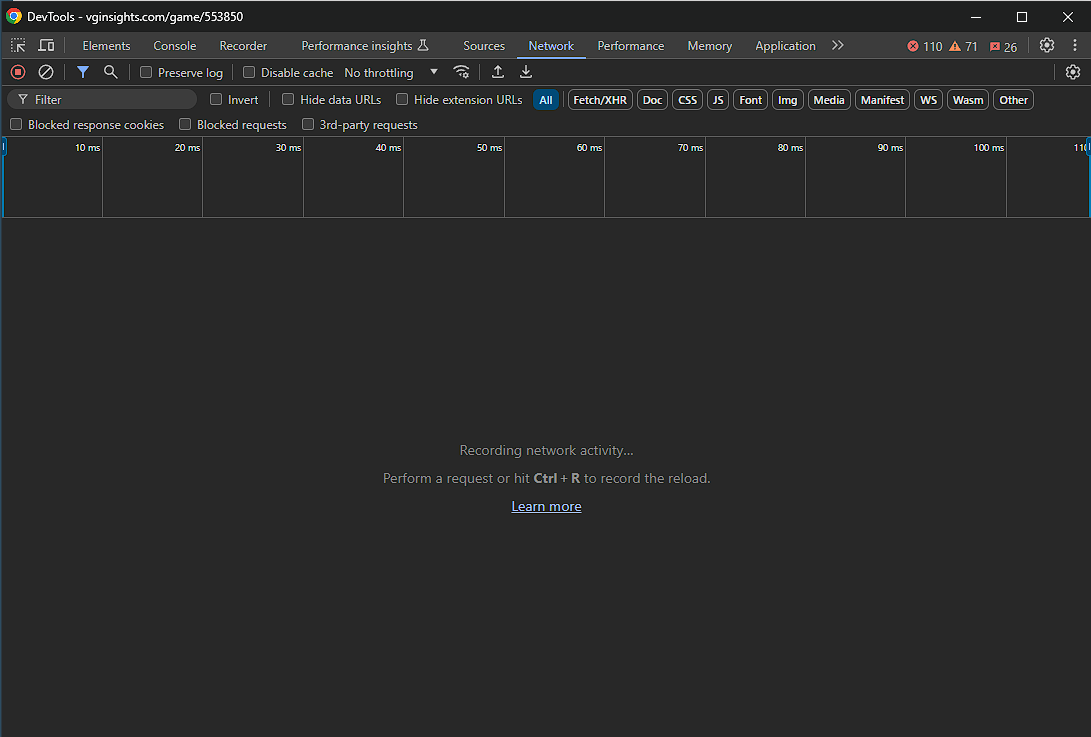

Ensure the network is being recorded in the top left of the screen and then refresh the page, this should populate the screen

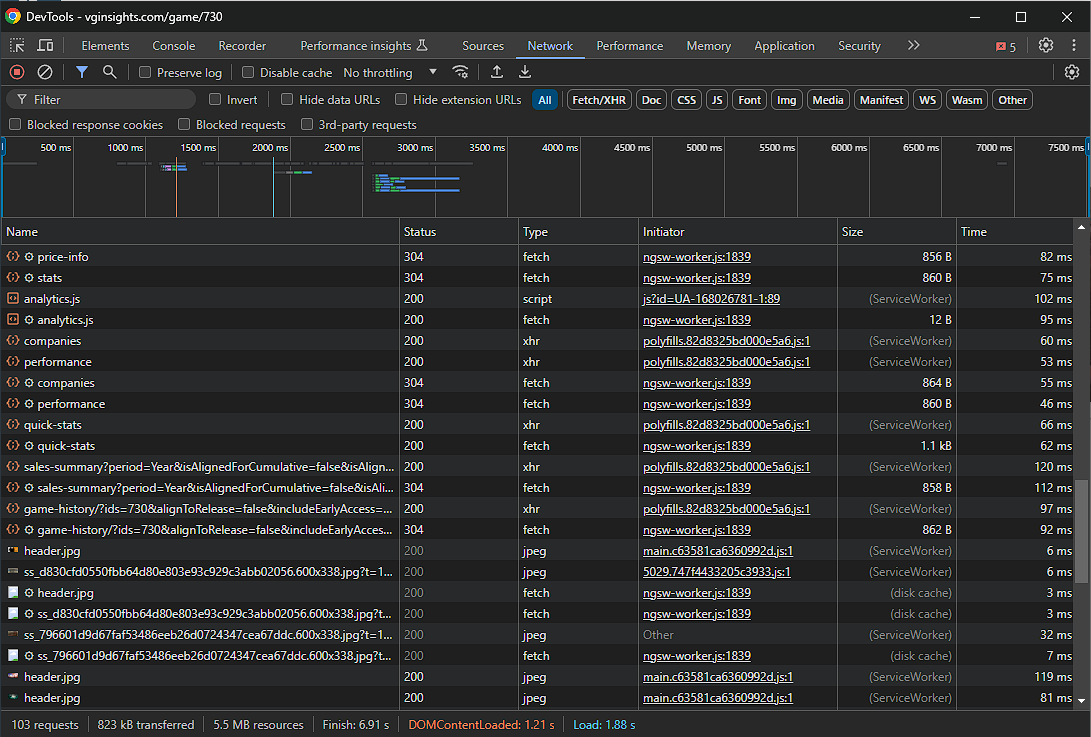

Find a name with the  symbol and select it. In the headers tab on the right scroll to the bottom to find your authorization token

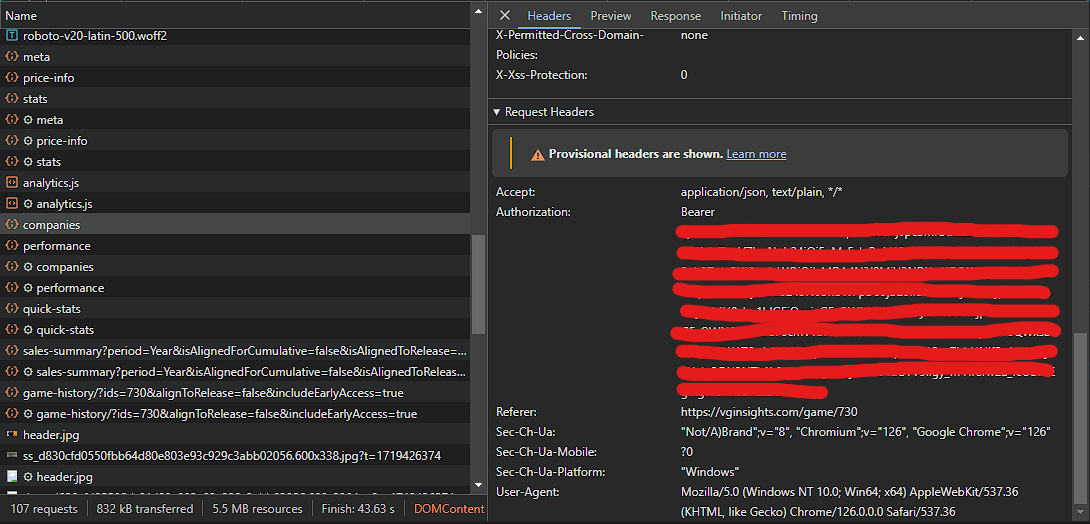

### DO NOT SHARE THIS TOKEN!!! This is for your use only

##### If you are missing the JWT token it may still work but will likely lead to error code 400 causing data in the output table to be missing

In [48]:
vgiHeaders = {
    'Authorization': 'Bearer <JWT token>'
}

In [49]:
def get_html_content(url):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
    }
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        return None
    return response.content

In [50]:
def get_game_details(url):
    steam_content = get_html_content(url)

    # get app id from steam url
    appid = url.split('/')[-3]

    if not steam_content:
        return

    soup = BeautifulSoup(steam_content, "html.parser")

    game_data = {}

    game = soup.find('div', {'id': 'appHubAppName'})
    if game:
        game_data['Game'] = game.text
    else:
        return

    developer = soup.find('div', {'id': 'developers_list'}).find('a').text.strip()
    game_data['Developer'] = developer

    publisher_section = soup.find('div', string='Publisher:').find_next_sibling('div')
    publisher = publisher_section.find('a').text.strip()
    game_data['Publisher'] = publisher

    release_date = soup.find('div', string='Release Date:').find_next_sibling('div').text
    game_data['Release Date'] = release_date

    purchase_wrapper = soup.find('div', {'class': 'game_area_purchase_game_wrapper'})
    if purchase_wrapper:
        price = purchase_wrapper.find('div', {'class': 'game_purchase_price'})
        if not price:
            price = purchase_wrapper.find('div', {'class': 'discount_original_price'})
        if price:
            game_data['Price'] = price.text.strip()
        else:
            game_data['Price'] = 'Err'

    response = requests.get(f'https://vginsights.com/api/v1/game/{appid}', headers=vgiHeaders)
    if response.status_code == 200:
        data = response.json()

        revenue = data['revenue_vgi']
        game_data['Revenue'] = f'£{int(revenue)*0.77:,.2f}'

        units = data['units_sold_vgi']
        game_data['Units Sold'] = f'{int(units):,}'

        review_count = data['reviews']
        game_data['Review Count'] = review_count

        review_positive = data['reviews_positive']
        review_negative = data['reviews_negative']
        game_data['Positive Reviews'] = review_positive
        game_data['Negative Reviews'] = review_negative

        review_score = data['rating']
        game_data['Review Score'] = f'{review_score}%'
    else:
        print('Error:', response.status_code, response.reason)

    response = requests.get(f'https://vginsights.com/api/v1/game/{appid}/quick-stats', headers=vgiHeaders)
    if response.status_code == 200:
        data = response.json()
        avg_playtime = data['avg_playtime']
        med_playtime = data['med_playtime']
        game_data['Average Playtime'] = round(avg_playtime / 60, 2) if avg_playtime else None
        game_data['Median Playtime'] = round(med_playtime / 60, 2) if med_playtime else None
    else:
        print('Error:', response.status_code, response.reason)

    game_data["Steam URL"] = url

    return game_data

In [51]:
# Function to read the URLs from the CSV content
def read_urls_from_csv_content(csv_content):
    urls = []
    lines = csv_content.decode('utf-8').splitlines()
    reader = csv.reader(lines)
    for row in reader:
        for url in row:
             if url.strip() not in urls:
                urls.append(url.strip())  # Add the URL to the list
    return urls

### Excel table will be saved in the same directory of this script

In [52]:
game_urls = []
csv_export_url = sheet_url.replace('/edit?','/export?format=csv&')

response = requests.get(csv_export_url)
game_urls = game_urls = read_urls_from_csv_content(response.content) # type: ignore

# Scrape data for each game
games_data = []
for url in game_urls:
    game_data = get_game_details(url)
    if game_data:
        games_data.append(game_data)

# Convert to DataFrame
df = pd.DataFrame(games_data)

# Save to Excel
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter("games_data.xlsx", engine='xlsxwriter')

# Convert the dataframe to an XlsxWriter Excel object. Turn off the default
# header and index and skip one row to allow us to insert a user defined
# header.
df.to_excel(writer, sheet_name='Sheet1', startrow=1, header=False, index=False)

# Get the xlsxwriter workbook and worksheet objects.
workbook = writer.book
worksheet = writer.sheets['Sheet1']

# Get the dimensions of the dataframe.
(max_row, max_col) = df.shape

# Create a list of column headers, to use in add_table().
column_settings = []
for header in df.columns:
    column_settings.append({'header': header})

# Add the table.
worksheet.add_table(0, 0, max_row, max_col - 1, {'columns': column_settings})

# Make the columns wider for clarity.
worksheet.set_column(0, max_col - 1, 24)

# Close the Pandas Excel writer and output the Excel file.
writer.close()

print(df)

                                     Game                     Developer  \
0                                 Impaler                      Apptivus   
1                           Devil Daggers                        Sorath   
2                                 KILLBUG                  Samurai Punk   
3                         Vampire Hunters             Gamecraft Studios   
4                                  REAVER                      MAD TRIO   
5                          Gunfire Reborn                   Duoyi Games   
6                       Kingpin: Reloaded           Slipgate Ironworks™   
7                 BPM: BULLETS PER MINUTE               Awe Interactive   
8                              Mortal Sin              Nikola Todorovic   
9                               AMID EVIL                 Indefatigable   
10                         MULLET MADJACK                      HAMMER95   
11              Warhammer 40,000: Boltgun                Auroch Digital   
12                       